# Model Evaluation Visualizations
## Generate ROC, PR, Confusion Matrix, and Feature Importance Plots

This notebook loads the trained models and generates comprehensive evaluation visualizations.

### Generated Plots:
1. **ROC Curve** (`roc.png`) - Receiver Operating Characteristic
2. **Precision-Recall Curve** (`pr.png`) - PR curve for imbalanced data
3. **Confusion Matrix** (`confusion.png`) - Classification results
4. **Feature Importance** (`feature_importance.png`) - Top features for each model

## 1. Setup & Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import joblib
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Models and Metadata

In [2]:
# Define paths
models_dir = Path('../models')
data_dir = Path('../data/clean')
figures_dir = Path('../docs/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

print("Loading models and metadata...")

# Load models
rf_model = joblib.load(models_dir / 'model_rf.pkl')
lgbm_model = joblib.load(models_dir / 'model_lgbm.pkl')
print("✓ Models loaded")

# Load metadata
with open(models_dir / 'metadata.json', 'r') as f:
    metadata = json.load(f)
print("✓ Metadata loaded")

# Load feature list
with open(models_dir / 'features.json', 'r') as f:
    features_data = json.load(f)
    feature_cols = features_data['features']
print(f"✓ Feature list loaded ({len(feature_cols)} features)")

Loading models and metadata...
✓ Models loaded
✓ Metadata loaded
✓ Feature list loaded (103 features)
✓ Models loaded
✓ Metadata loaded
✓ Feature list loaded (103 features)


## 3. Prepare Test Data

In [3]:
# Load cleaned data
print("Loading test data...")
df = pd.read_csv(data_dir / 'kepler_clean.csv')

# Create binary target (same as training)
df_binary = df[df['koi_disposition'].isin(['CONFIRMED', 'FALSE POSITIVE'])].copy()
df_binary['label'] = (df_binary['koi_disposition'] == 'CONFIRMED').astype(int)

# Recreate train/test split (same random state as training)
from sklearn.model_selection import train_test_split

X = df_binary[feature_cols].copy()
y = df_binary['label'].copy()

# Handle missing values (same as training)
for col in feature_cols:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

# Split (using same random state as training)
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Generate predictions
print("\nGenerating predictions...")
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

print(f"✓ Test set: {len(y_test):,} samples")
print("✓ Predictions generated for both models")

Loading test data...

Generating predictions...
✓ Test set: 1,517 samples
✓ Predictions generated for both models
✓ Test set: 1,517 samples
✓ Predictions generated for both models


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


## 4. ROC Curve

✓ ROC curve saved: ../docs/figures/roc.png


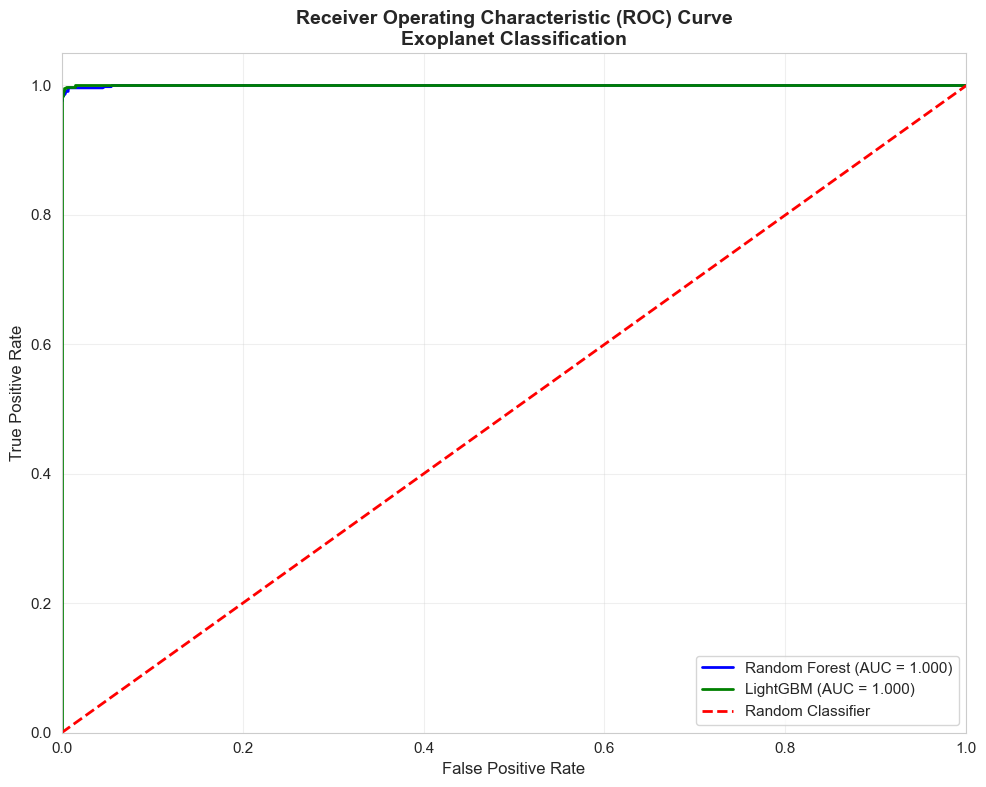

In [4]:
# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Create ROC plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, 
         label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_lgbm, tpr_lgbm, color='green', lw=2, 
         label=f'LightGBM (AUC = {roc_auc_lgbm:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve\nExoplanet Classification', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
roc_path = figures_dir / 'roc.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f"✓ ROC curve saved: {roc_path}")
plt.show()

## 5. Precision-Recall Curve

✓ PR curve saved: ../docs/figures/pr.png


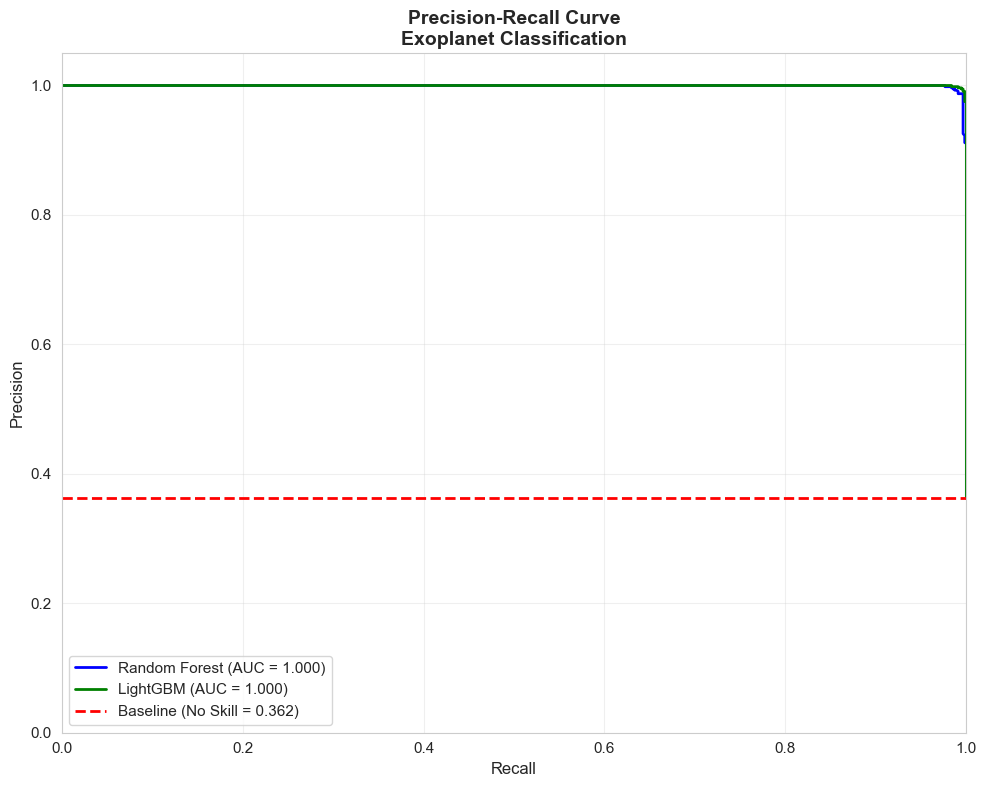

In [5]:
# Calculate PR curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)

precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
pr_auc_lgbm = auc(recall_lgbm, precision_lgbm)

# Baseline (proportion of positive class)
baseline = y_test.sum() / len(y_test)

# Create PR plot
plt.figure(figsize=(10, 8))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, 
         label=f'Random Forest (AUC = {pr_auc_rf:.3f})')
plt.plot(recall_lgbm, precision_lgbm, color='green', lw=2, 
         label=f'LightGBM (AUC = {pr_auc_lgbm:.3f})')
plt.axhline(y=baseline, color='red', lw=2, linestyle='--', 
            label=f'Baseline (No Skill = {baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve\nExoplanet Classification', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
pr_path = figures_dir / 'pr.png'
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
print(f"✓ PR curve saved: {pr_path}")
plt.show()

## 6. Confusion Matrices

✓ Confusion matrices saved: ../docs/figures/confusion.png


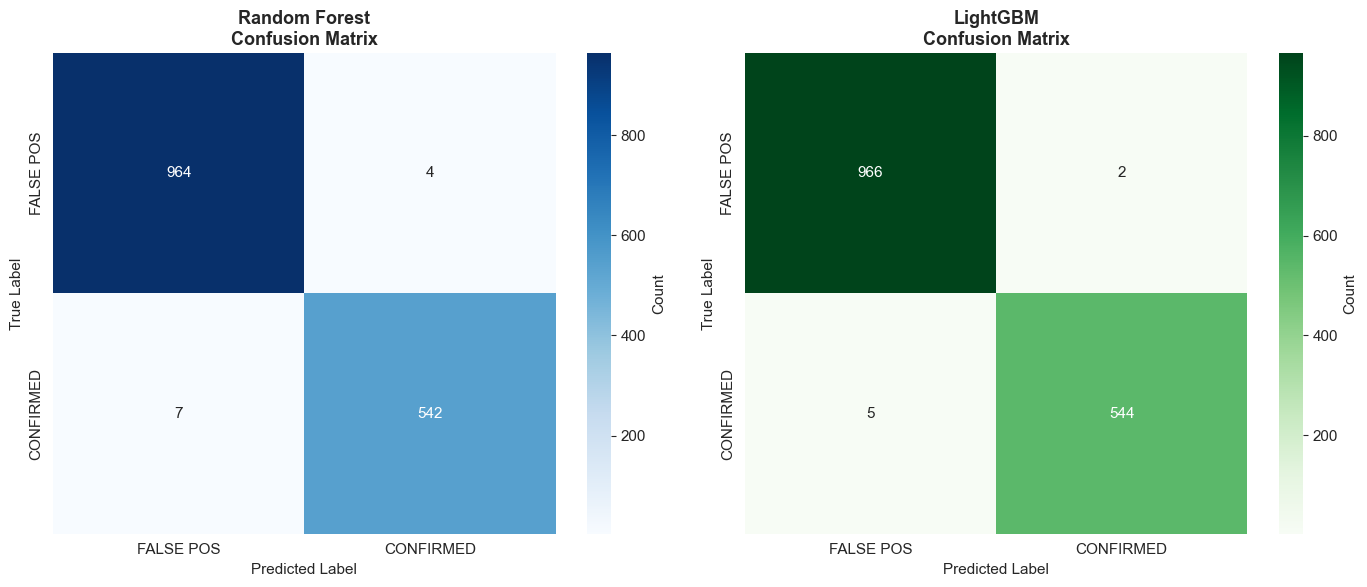

In [6]:
# Calculate confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Create side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FALSE POS', 'CONFIRMED'],
            yticklabels=['FALSE POS', 'CONFIRMED'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Random Forest\nConfusion Matrix', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# LightGBM
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['FALSE POS', 'CONFIRMED'],
            yticklabels=['FALSE POS', 'CONFIRMED'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('LightGBM\nConfusion Matrix', fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()

# Save figure
confusion_path = figures_dir / 'confusion.png'
plt.savefig(confusion_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrices saved: {confusion_path}")
plt.show()

## 7. Feature Importance

✓ Feature importance plot saved: ../docs/figures/feature_importance.png


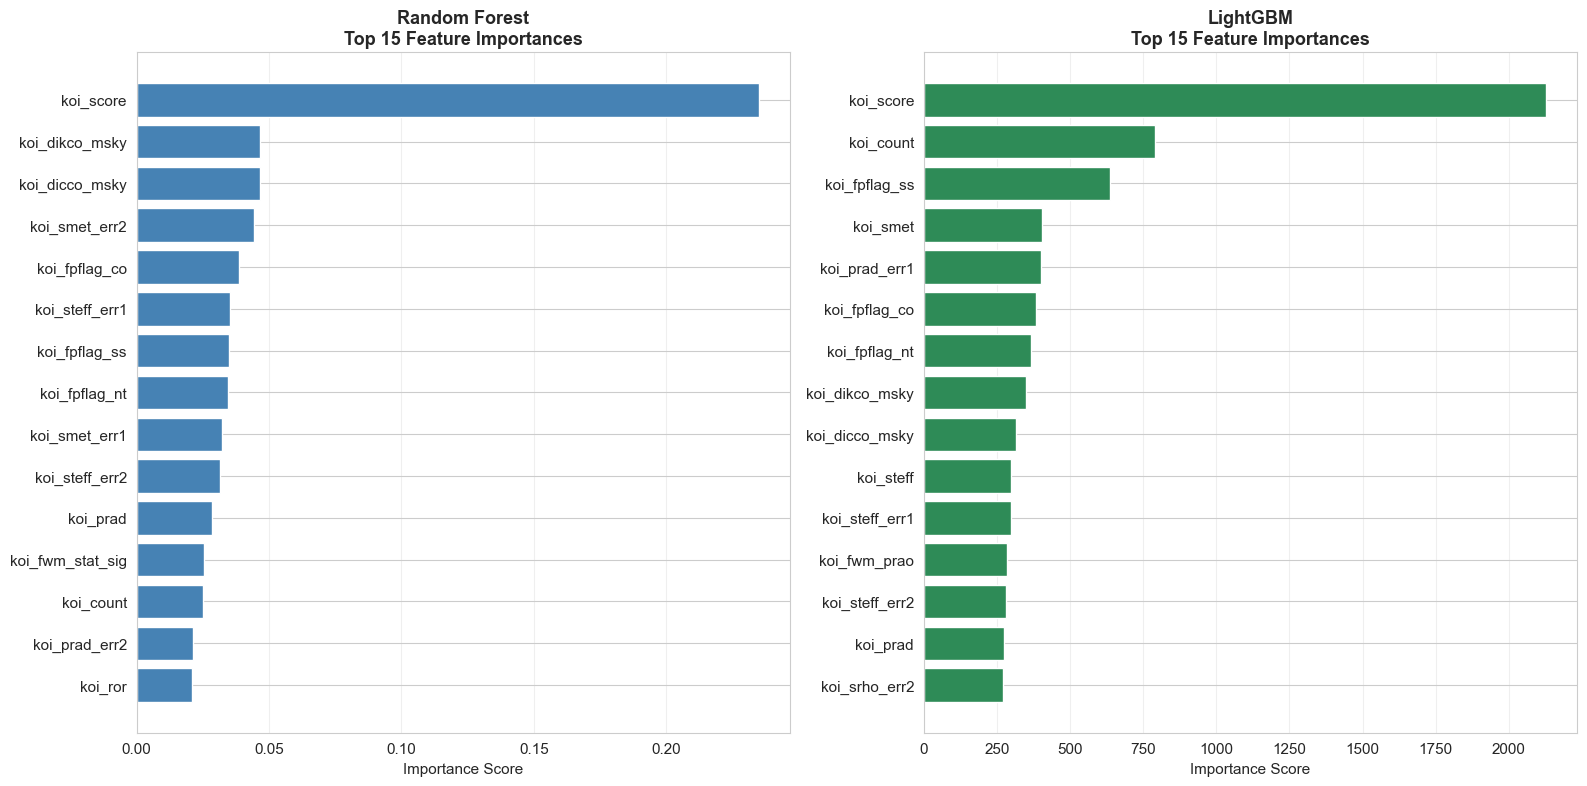

In [7]:
# Get feature importances
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

lgbm_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Create side-by-side feature importance plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
axes[0].barh(range(len(rf_importance)), rf_importance['importance'], color='steelblue')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['feature'])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Random Forest\nTop 15 Feature Importances', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# LightGBM
axes[1].barh(range(len(lgbm_importance)), lgbm_importance['importance'], color='seagreen')
axes[1].set_yticks(range(len(lgbm_importance)))
axes[1].set_yticklabels(lgbm_importance['feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('LightGBM\nTop 15 Feature Importances', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()

# Save figure
importance_path = figures_dir / 'feature_importance.png'
plt.savefig(importance_path, dpi=300, bbox_inches='tight')
print(f"✓ Feature importance plot saved: {importance_path}")
plt.show()

## Summary

### ✅ Generated Visualizations:
All evaluation plots have been saved to `docs/figures/`:
- `roc.png` - ROC curves comparing both models
- `pr.png` - Precision-Recall curves for imbalanced data assessment
- `confusion.png` - Confusion matrices showing classification results
- `feature_importance.png` - Top features driving each model's predictions

These visualizations are ready to be included in the model card and documentation.

---
*Evaluation plots generated successfully!*